# Correlation Analysis

In [1]:
%load_ext autoreload

In [2]:
# Imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
import csv
import warnings
import seaborn as sns
import openpyxl
from scipy import stats

# Sklearn Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Py File Imports
from supporting_functions import get_fp, loadData, saveData


# Get Correct Filepath
#cpu = "surface"
cpu = "man_dtop"
#cpu = "sean"

# Call Functions
folder_fp, data_fp, figures_fp = get_fp(cpu, figuresFolder="3.correlationPCA/")
rawPhys, rawRheo, physDict, rheoDict, imputedRheo = loadData(data_fp)

In [3]:
# Subset
abrSubset = ['donors', 'HCT', 'FIB', 'CHOL', 'TRIG', 'HDL', 'LDL', 
            'WBC', 'RBC', 'HEM', 'MCV', 'MCH', 'MCHC']

# Create a Mapping
rename_mapping = {}
for full_name, props in physDict.items():
    abbr = props.get('abbreviation')
    if abbr in abrSubset:
        rename_mapping[physDict[full_name]["column_name"]] = abbr
        
# Rename the columns
subset_Phys = rawPhys.rename(columns=rename_mapping)
#subset_Phys = subset_Phys[abrSubset]

# Clean NA from Rheological Data
cleanedRheo = rawRheo
# Remove Ibservation from Donor M
cleanedRheo = cleanedRheo[cleanedRheo["donors"] != "M"]

# Define Targets
rheo_targets = ["MU_0", "MU_INF", "TAU_C", "T_R1", "T_R2", "MU_R", "SIGMA_Y0", "TAU_LAM", "G_R", "G_C"]
rheo_columns = [value["column_name"] for value in rheoDict.values()][1::]

In [4]:
# Create X
X = subset_Phys[abrSubset[1::]].values
#X = subset_Phys.iloc[:, 1:-1].values

# Standardize and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Extract target values
y_data = imputedRheo

In [6]:
# Use Imputed Rheological Data

# Merge with Rheology Data
merged_df = pd.merge(subset_Phys[['donors']], imputedRheo, on='donors')

# Extract rheological parameters (excluding the donor column)
params = [col for col in rawRheo.columns if col != 'donors']
rheology_params = []
for p in params:
    if p in rheoDict.keys():
        rheology_params.append(rheoDict[p]["latex_name"])
        
Y_rheology = merged_df[params].values

# Create a DataFrame with the principal components
n_components_to_analyze = 8  # We'll focus on the first 8 PCs
pc_columns = [f'PC{i+1}' for i in range(n_components_to_analyze)]
pc_df = pd.DataFrame(X_pca[:, :n_components_to_analyze], columns=pc_columns)

# Calculate correlations between PCs and rheological parameters
correlation_matrix = np.zeros((n_components_to_analyze, len(rheology_params)))
p_values = np.zeros((n_components_to_analyze, len(rheology_params)))

for i in range(n_components_to_analyze):
    for j in range(len(rheology_params)):
        # Calculate Pearson correlation and p-value
        r, p = stats.pearsonr(X_pca[:, i], Y_rheology[:, j])
        correlation_matrix[i, j] = r
        p_values[i, j] = p

# Create a nice correlation DataFrame for viewing
corr_df = pd.DataFrame(correlation_matrix,
                       index=pc_columns,
                       columns=rheology_params)

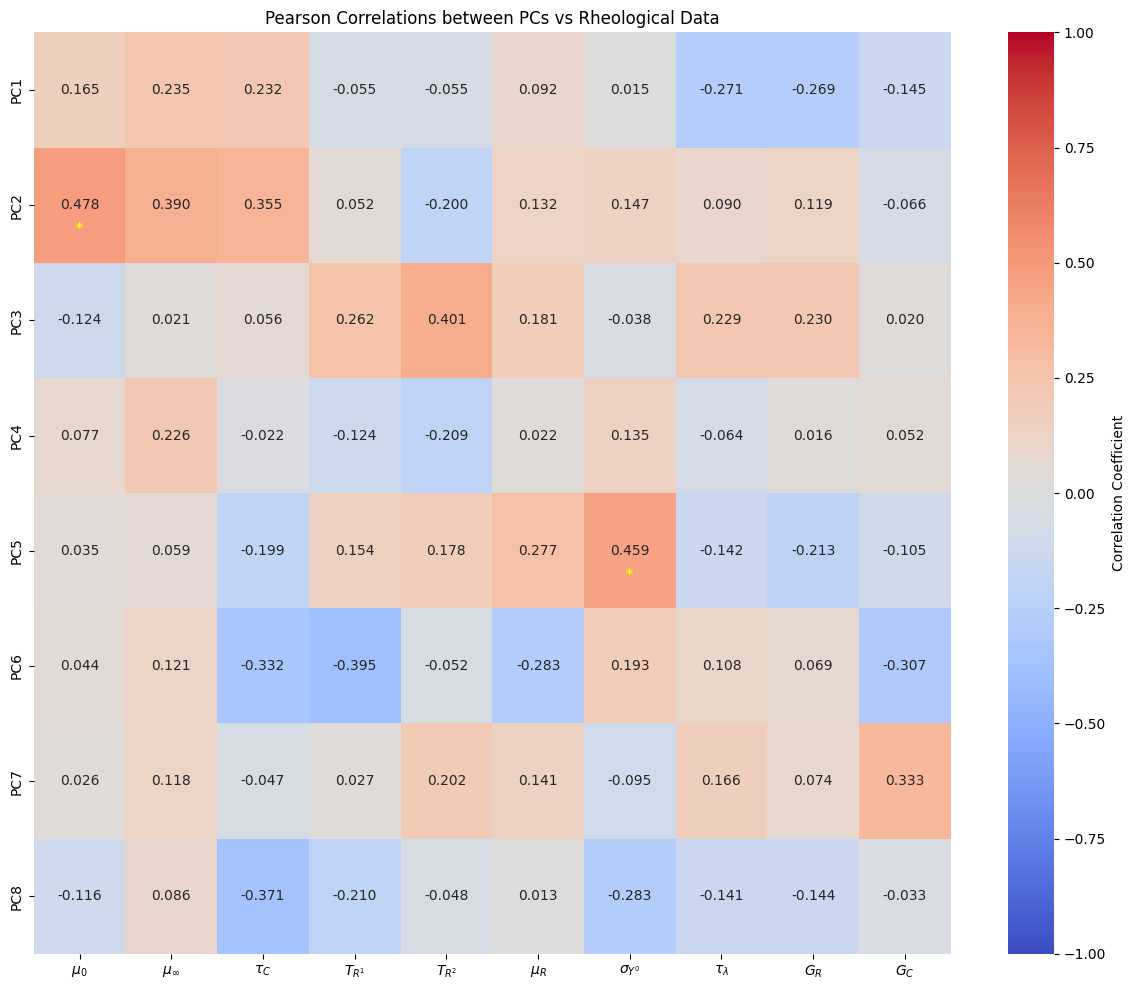

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Pearson Correlations between PCs vs Rheological Data')

# Add significance stars (only for non-NaN values)
ax = plt.gca()
for i in range(n_components_to_analyze):
    for j in range(len(rheology_params)):
        if not np.isnan(p_values[i, j]):
            if p_values[i, j] < 0.001:
                ax.text(j+0.5, i+0.7, '***', ha='center', va='center', 
                        color='yellow', fontweight='bold')
            elif p_values[i, j] < 0.01:
                ax.text(j+0.5, i+0.7, '**', ha='center', va='center', 
                        color='yellow', fontweight='bold')
            elif p_values[i, j] < 0.05:
                ax.text(j+0.5, i+0.7, '*', ha='center', va='center', 
                        color='yellow', fontweight='bold')
plt.tight_layout()
fp = figures_fp + 's3_007_corrPCAHeatmap.png'
plt.savefig(fp, dpi=300, bbox_inches='tight')
plt.show()

In [33]:

# Pick a PC
pc_idx = 1  # PC1 (0-indexed)

# Pick a Parameter
print(rheoDict.keys())
param = r'mu_0 (Pa s)'
rheo_idx = rheology_params.index(rheoDict[param]['latex_name'])

dict_keys(['Donor', 'mu_0 (Pa s)', 'mu_inf (Pa s)', 'tau_C (s)', 't_r1 (s)', 't_r2 (s)', 'mu_R (Pa s)', 'sigma_y0 (Pa)', 'tau_lam (s)', 'G_R (Pa)', 'G_C (Pa)'])


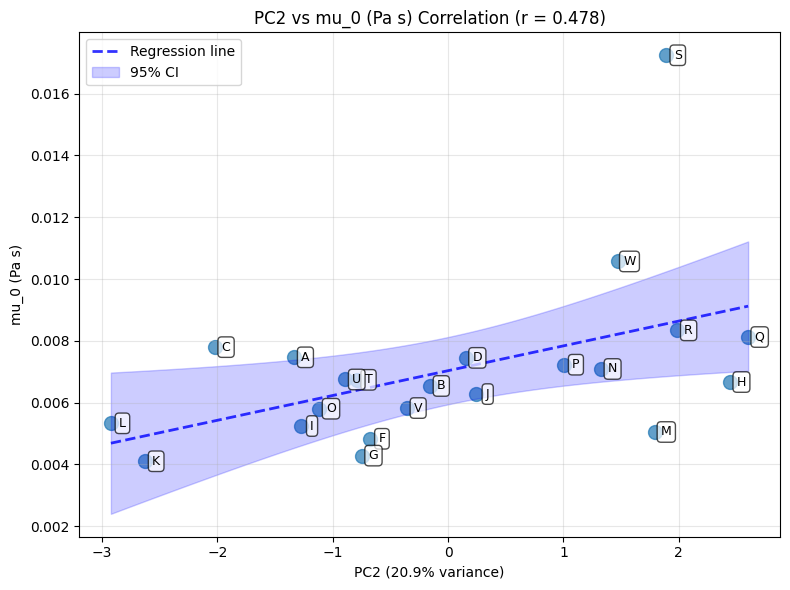

In [34]:
plt.figure(figsize=(8, 6))

# Calculate correlation
correlation_r = np.corrcoef(X_pca[:, pc_idx], Y_rheology[:, rheo_idx])[0, 1]

# Scatter plot
plt.scatter(X_pca[:, pc_idx], Y_rheology[:, rheo_idx], 
           alpha=0.7, s=100)

labels = []
for i in range(len(X_pca)):
    letter_index = i if i < 4 else i + 1  # Skip E
    labels.append(chr(65 + letter_index))

for i, label in enumerate(labels):
    plt.text(X_pca[i, pc_idx] + 0.1, Y_rheology[i, rheo_idx], label, 
             fontsize=9, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

# Add regression line with confidence interval
z = np.polyfit(X_pca[:, pc_idx], Y_rheology[:, rheo_idx], 1)
p = np.poly1d(z)
x_line = np.linspace(X_pca[:, pc_idx].min(), X_pca[:, pc_idx].max(), 100)
y_line = p(x_line)

# Calculate 95% confidence interval
from scipy import stats
n = len(X_pca[:, pc_idx])
x_mean = np.mean(X_pca[:, pc_idx])
sxx = np.sum((X_pca[:, pc_idx] - x_mean)**2)
sxy = np.sum((X_pca[:, pc_idx] - x_mean) * (Y_rheology[:, rheo_idx] - np.mean(Y_rheology[:, rheo_idx])))
syy = np.sum((Y_rheology[:, rheo_idx] - np.mean(Y_rheology[:, rheo_idx]))**2)
s = np.sqrt((syy - sxy**2/sxx) / (n-2))
t = stats.t.ppf(0.975, n-2)  # 95% CI

ci = t * s * np.sqrt(1/n + (x_line - x_mean)**2/sxx)

plt.plot(x_line, y_line, "b--", alpha=0.8, linewidth=2, label='Regression line')
plt.fill_between(x_line, y_line - ci, y_line + ci, alpha=0.2, color='blue', label='95% CI')

plt.xlabel(f'PC2 ({pca.explained_variance_ratio_[pc_idx]*100:.1f}% variance)')
plt.ylabel(param)
plt.title(f'PC2 vs {param} Correlation (r = {correlation_r:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
fp = figures_fp + f'pc2_{param}_correlation.png'
plt.savefig(fp, dpi=300, bbox_inches='tight')
plt.show()

In [10]:

# Create summary table
print("\n=== COMPLETE CORRELATION SUMMARY ===")
summary_data = []
for param in rheology_params:
    param_corrs = corr_df[param].dropna()
    if len(param_corrs) > 0:
        abs_corrs = param_corrs.abs()
        max_pc = abs_corrs.idxmax()
        max_corr = corr_df.loc[max_pc, param]
        summary_data.append({
            'Parameter': param,
            'Best PC': max_pc,
            'Correlation': max_corr,
            'Abs Correlation': abs(max_corr)
        })
    else:
        summary_data.append({
            'Parameter': param,
            'Best PC': 'None',
            'Correlation': np.nan,
            'Abs Correlation': 0
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Abs Correlation', ascending=False)
print(summary_df)


=== COMPLETE CORRELATION SUMMARY ===
          Parameter Best PC  Correlation  Abs Correlation
0           $\mu_0$     PC2     0.478442         0.478442
6  $\sigma_{Y^{0}}$     PC5     0.459345         0.459345
4         $T_{R^2}$     PC3     0.400829         0.400829
3         $T_{R^1}$     PC6    -0.394814         0.394814
1    $\mu_{\infty}$     PC2     0.389760         0.389760
2          $\tau_C$     PC8    -0.371449         0.371449
9             $G_C$     PC7     0.333221         0.333221
5           $\mu_R$     PC6    -0.283131         0.283131
7  $\tau_{\lambda}$     PC1    -0.271138         0.271138
8             $G_R$     PC1    -0.268993         0.268993
